# Visual Analysis
_code used to visual analysis_

## import package

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud as wc
import scipy.sparse as sparse
import sklearn

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold,train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
saving = False

## load data

In [3]:
movies = pd.read_csv("Documents/datamining/dataset/movies_metadata.csv")
keywords = pd.read_csv("Documents/datamining/dataset/keywords.csv")

## visual analysis methods

### helper funtions

In [4]:
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def get_groups(series,index="name"):
    s=set()
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:s.add(x[index])
    return list(s)

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

### pie chart of numbers of movies released in each decade

In [5]:
def count_pie(series,filename):
    counts=series.value_counts()
    counts=counts/counts.sum()
    labels=['' if num<0.01 else str(year) for (year,num) in counts.items()]
    f, ax = plt.subplots(figsize=(8, 8))
    explode = [0.02 if counts.iloc[i] < 100 else 0.001 for i in range(counts.size)]
    plt.pie(counts,labels=labels,autopct=lambda x:'{:1.0f}%'.format(x) if x > 1 else '',explode=explode)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

def count_decade_pie(df,filename):
    count_pie(df.release_date.dropna().apply(lambda x:str(int(x[:4])//10*10)+'s'),filename)

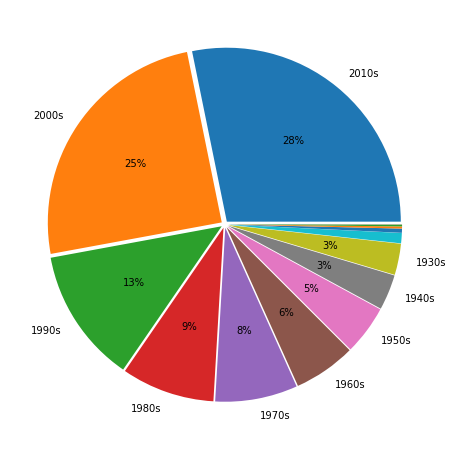

In [6]:
count_decade_pie(movies,filename="pie_decade.png")

### bar chart of numbers of movies of different genres

In [7]:
def multi_bar(series,filename):
    sns.set(style="whitegrid")
    count=multi_count(series,"name")
    count=sorted(count.items(),key=lambda x:x[1],reverse=True)
    count=dict(count[:20])
    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=85, fontsize=15)
    plt.bar(count.keys(),count.values(),align="center")
    if saving:plt.savefig(filename,bbox_inches="tight",dpi=100)
    plt.show()

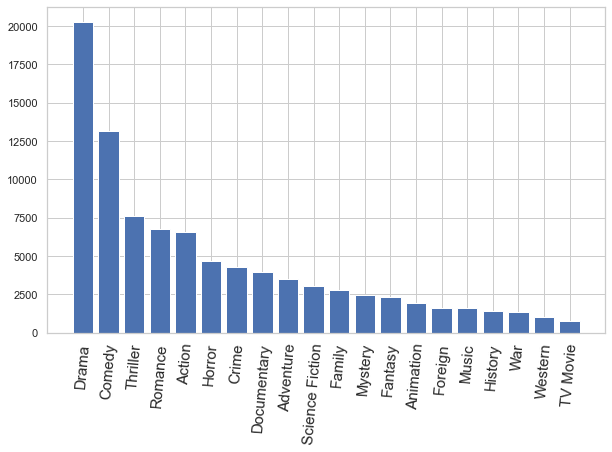

In [8]:
multi_bar(movies.genres,filename="bar_genres.png")

### wordcloud of genres and keywords for all movies

In [9]:
def multi_wordcloud(series,filename):
    w = wc.WordCloud(background_color="white", margin=20, width=800, height=600, prefer_horizontal=0.7, max_words=50,
                     scale=2)
    count = multi_count(series, "name")
    w.generate_from_frequencies(count)
    if saving: w.to_file(filename)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(w)
    plt.show()

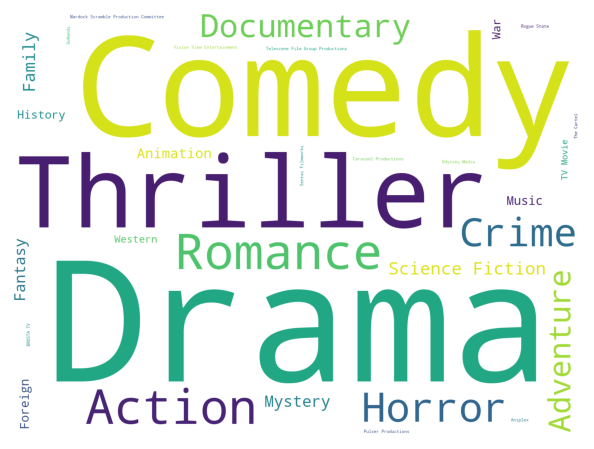

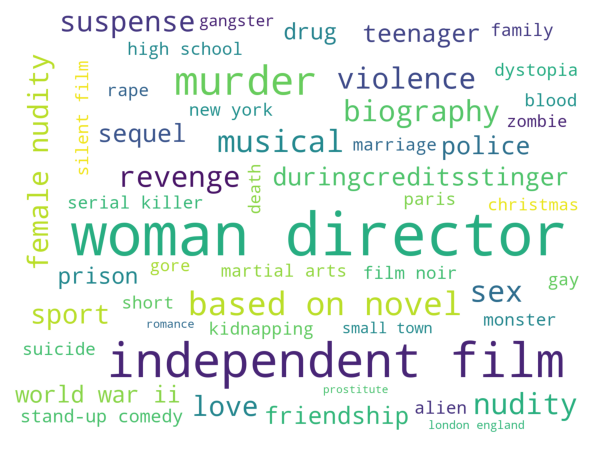

In [10]:
multi_wordcloud(movies.genres, filename="wordcloud_genres.png")
multi_wordcloud(keywords.keywords, filename="wordcloud_keywords.png")

### change of percentage of movies of each genres released in each decade

In [11]:
def multi_stackplot_10year(df,value,filename):
    sns.set(style="whitegrid")
    df=df[["release_date",value]].dropna()
    df.release_date=df.release_date.apply(lambda x:int(x[:4])//10*10)
    df=df.sort_values("release_date")
    # years=pd.Series(range(df["release_date"].min(),df["release_date"].max()+1,10),name="year")
    years = pd.Series(range(1910, df["release_date"].max() + 1, 10), name="year")
    counts=[]
    groups=[]
    for (name,col) in multi_groupby(df,"genres","name"):
        groups.append(name)
        counts.append(pd.merge(years.to_frame(),col.groupby("release_date").size().rename("count").to_frame(),
                               how="left",left_on="year",right_on="release_date").fillna(0).astype(int)["count"])
    counts=np.array(counts)
    counts=counts.transpose(0,1)
    counts=counts/counts.sum(0)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.stackplot(years,counts,labels=groups)
    plt.xticks(years)
    plt.xlim(years.iloc[0],years.iloc[-1])
    plt.ylim(0,1)
    plt.legend()
    if saving: plt.savefig(filename, dpi=200)
    plt.show()

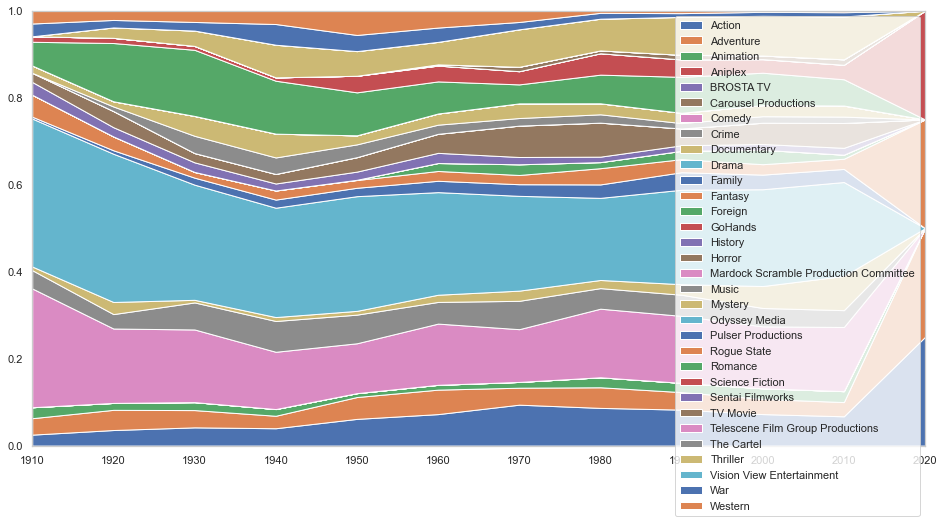

In [12]:
multi_stackplot_10year(movies,"genres",filename="stackplot_genres.png")

### box plot or violin plot of runtime groupby genres

In [13]:
def plotby_box(df, x, y, filename, yscale="linear"):
    sns.set(style="whitegrid")
    df = df.replace(0, np.nan).copy()
    f, ax = plt.subplots(figsize=(20, 10))
    sns.boxenplot(data=expand_multi_feature(df, x, "name"), x=x, y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55, fontsize=20)
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=30)
    if saving: plt.savefig(filename, bbox_inches="tight", dpi=150)
    plt.show()


def plotby_violin(df, x, y, filename, yscale="linear"):
    sns.set(style="whitegrid")
    df = df.replace(0, np.nan).copy()
    f, ax = plt.subplots(figsize=(20, 10))
    sns.violinplot(data=expand_multi_feature(df, x, "name"), x=x, y=y)
    plt.yscale(yscale)
    plt.yticks(fontsize=20)
    plt.xticks(rotation=55, fontsize=20)
    plt.xlabel(x, fontsize=20)
    plt.ylabel(y, fontsize=30)
    if saving: plt.savefig(filename, bbox_inches="tight", dpi=150)
    plt.show()

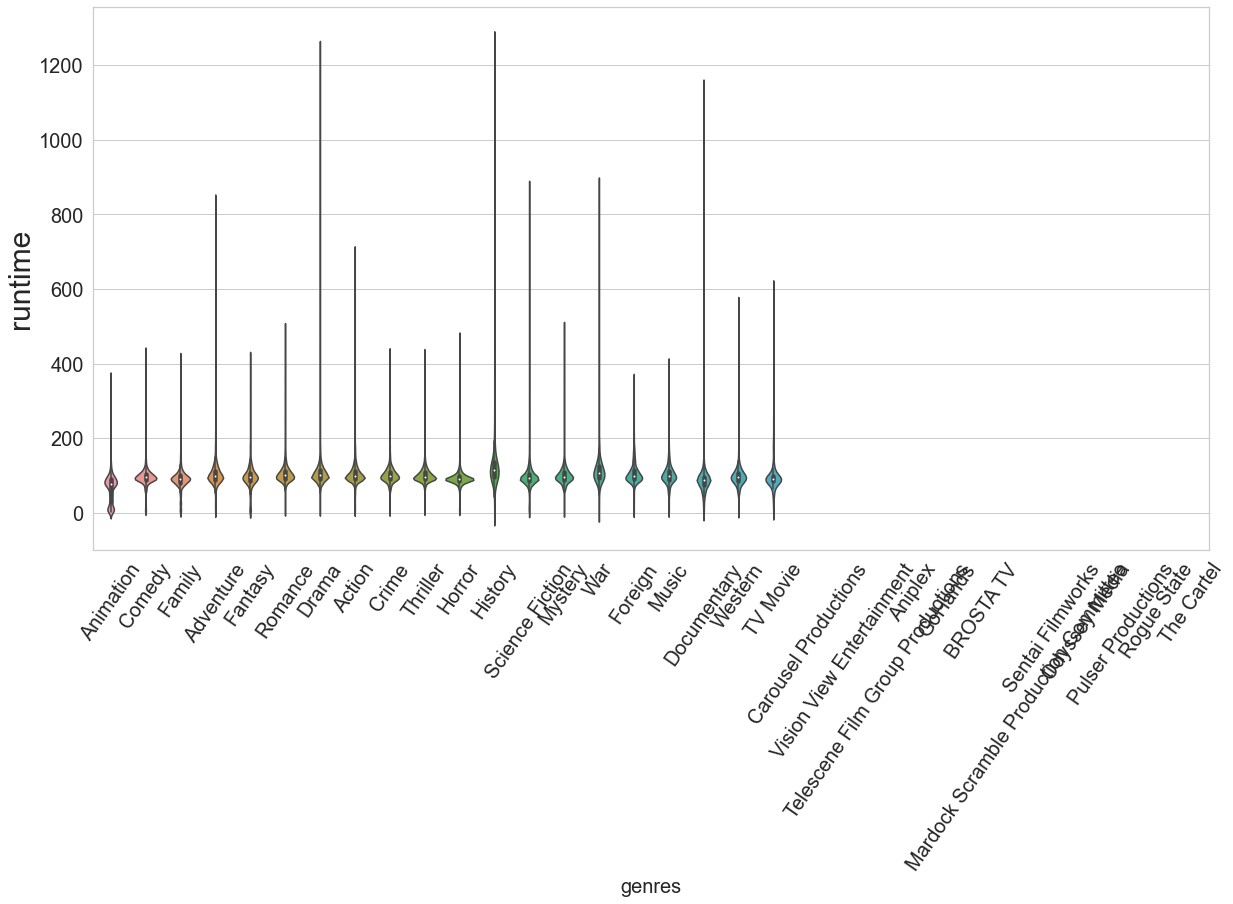

In [14]:
plotby_violin(movies,"genres","runtime",yscale="linear",filename="genres_runtime.png")

### word cloud of keywords in different decades

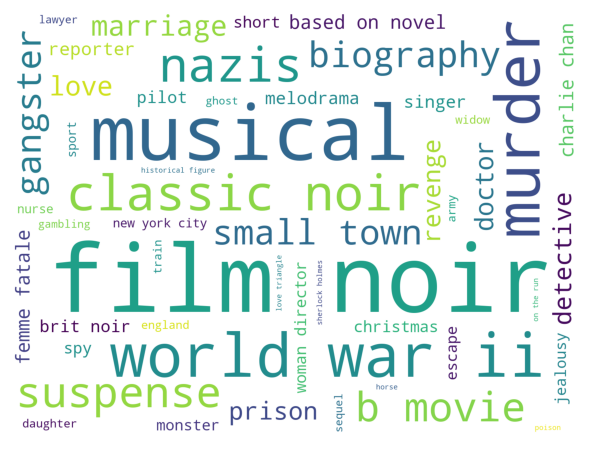

In [15]:
movies.dropna(axis=0, subset=['release_date'], inplace=True)
movies1940 = movies[movies['release_date'].apply(lambda x: int(x[:4]) // 10 * 10 == 1940)]
available_ids = movies1940['id']
available_ids = [int(available_ids[i]) for i in available_ids.index]
id2keywords = {keywords['id'][i]: keywords['keywords'][i] for i in keywords.index}
all_keywords = pd.Series([id2keywords[id] for id in available_ids])

multi_wordcloud(all_keywords, filename="wordcloud_keywords_1940.png")

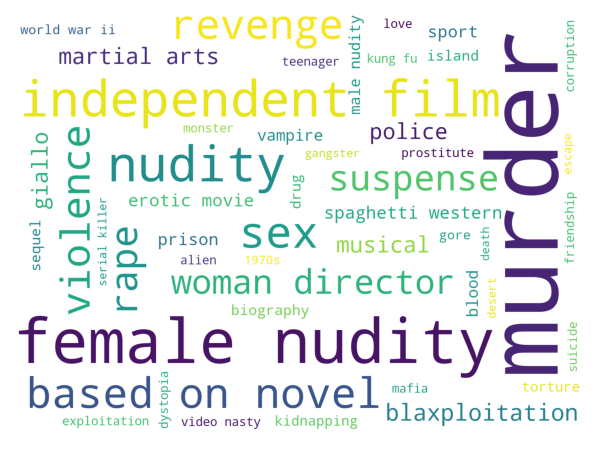

In [16]:
movies1970 = movies[movies['release_date'].apply(lambda x: int(x[:4]) // 10 * 10 == 1970)]
available_ids = movies1970['id']
available_ids = [int(available_ids[i]) for i in available_ids.index]
id2keywords = {keywords['id'][i]: keywords['keywords'][i] for i in keywords.index}
all_keywords = pd.Series([id2keywords[id] for id in available_ids])

multi_wordcloud(all_keywords, filename="wordcloud_keywords_1970.png")

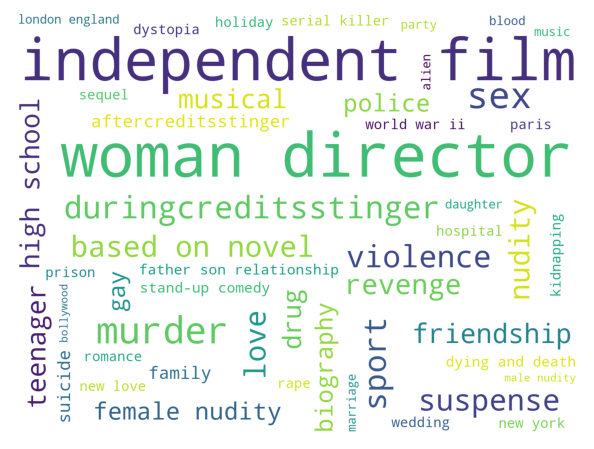

In [17]:
movies = movies[movies['release_date'].apply(lambda x: int(x[:4]) // 10 * 10 == 2000)]
available_ids = movies['id']
available_ids = [int(available_ids[i]) for i in available_ids.index]
id2keywords = {keywords['id'][i]: keywords['keywords'][i] for i in keywords.index}
all_keywords = pd.Series([id2keywords[id] for id in available_ids])

multi_wordcloud(all_keywords, filename="wordcloud_keywords_2000.png")

### Correlogram of correlation between numeric features

In [18]:
def plot_corr(df,filename):
    plt.subplots(figsize=(12, 9))
    sns.heatmap(df.corr(),annot=True,linewidths=.5,annot_kws={"fontsize":15})
    plt.yticks(rotation=0,fontsize=15)
    plt.xticks(rotation=0,fontsize=15)
    if saving:plt.savefig(filename,dpi=150)
    plt.show()

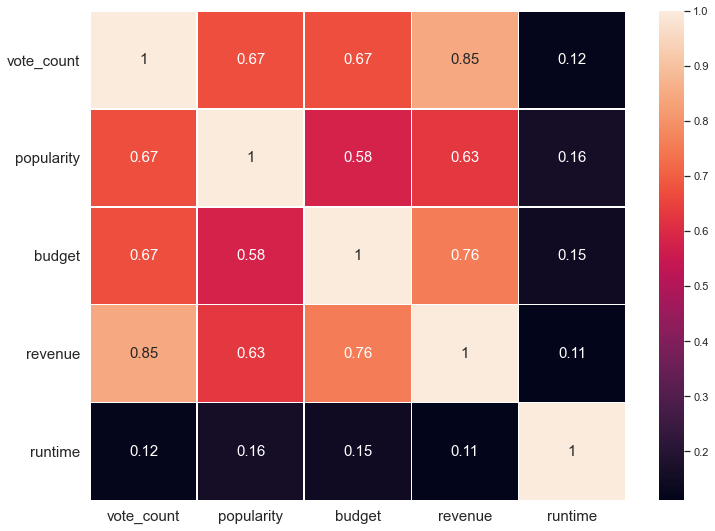

In [19]:
df1 =  movies[["vote_count","popularity","budget","revenue","runtime"]].apply(lambda x:x.astype(float))
plot_corr(df1,filename="corr.png")